Experimentation with spline-based spatial interpolation

In [1]:
import pandas as pd
import json

import matplotlib.pyplot as plt


In [2]:
# Read data
data = pd.read_csv("/storage/bln-aq/data/chronos-predictions-2024.csv")

with open("/storage/bln-aq/data/loc_dict.json", "r") as f:
    location_dict = json.load(f)

In [3]:
data

,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,1,2025-01-01,target,12.861274,6.902672,12.861274,22.115465
1,1,2025-01-02,target,10.422829,4.647019,10.422829,20.709976
2,1,2025-01-03,target,9.533712,3.900051,9.533712,19.646904
3,2,2025-01-01,target,9.666606,4.611566,9.666606,20.131985
4,2,2025-01-02,target,8.891564,3.769809,8.891564,20.640490
...,...,...,...,...,...,...,...
580,196,2025-01-02,target,10.892285,4.207911,10.892285,22.540287
581,196,2025-01-03,target,9.470917,3.326665,9.470917,21.035177
582,197,2025-01-01,target,6.241824,3.064982,6.241824,10.848845
583,197,2025-01-02,target,4.820718,1.906550,4.820718,10.003038


In [4]:
location_dict

{'1': [52.34112525, 13.4041644],
 '2': [52.346, 13.096],
 '3': [52.34779846, 13.09706837],
 '4': [52.348, 13.66],
 '5': [52.35, 13.402],
 '6': [52.37, 13.314],
 '7': [52.372, 13.61],
 '8': [52.374, 13.132],
 '9': [52.37799003, 13.0912292],
 '10': [52.378, 13.122],
 '11': [52.378, 13.404],
 '12': [52.384, 13.396],
 '13': [52.38535529, 13.39390469],
 '14': [52.38735672, 13.38938764],
 '15': [52.388, 13.096],
 '16': [52.388, 13.39],
 '17': [52.39202801, 13.09366014],
 '18': [52.39808494, 13.4004126],
 '19': [52.406, 13.23],
 '20': [52.406, 13.416],
 '21': [52.408, 13.356],
 '22': [52.408, 13.5],
 '23': [52.412, 13.554],
 '24': [52.41204745, 13.3361361],
 '25': [52.41252655, 13.1085392],
 '26': [52.4128266, 13.4208877],
 '27': [52.41369779, 13.27334046],
 '28': [52.41768788, 13.34519148],
 '29': [52.418, 13.398],
 '30': [52.418, 13.668],
 '31': [52.42, 13.334],
 '32': [52.422, 13.486],
 '33': [52.428, 13.302],
 '34': [52.436, 13.312],
 '35': [52.436, 13.346],
 '36': [52.4416178, 13.4175126

     timestamp target_name  predictions        lat        lon
0   2025-01-01      target    12.861274  52.341125  13.404164
3   2025-01-01      target     9.666606  52.346000  13.096000
6   2025-01-01      target     6.110032  52.347798  13.097068
9   2025-01-01      target     0.887576  52.348000  13.660000
12  2025-01-01      target     8.726306  52.350000  13.402000


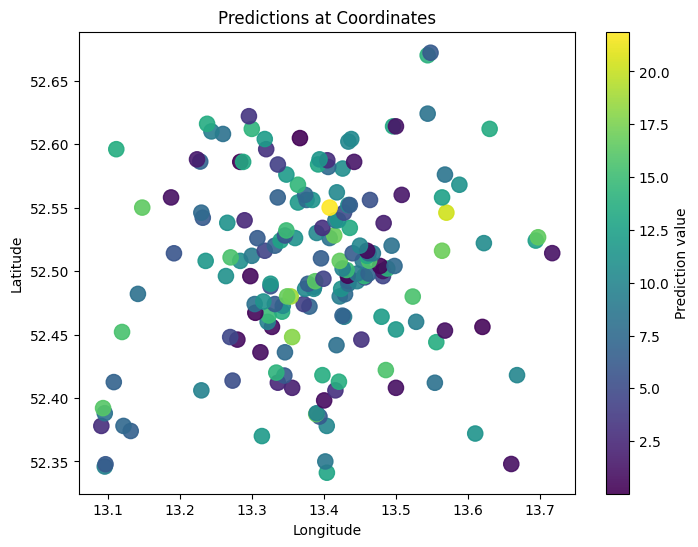

In [5]:
# Just look at chronos pred timestep 1
data = data[data["timestamp"] == "2025-01-01"]
data.head()

z = data["predictions"]

Q1 = z.quantile(0.25)
Q3 = z.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

data = data[(z >= lower) & (z <= upper)].copy()

# Map item_id to coordinates
data[['lat', 'lon']] = data['item_id'].map(lambda x: location_dict[str(x)]).apply(pd.Series)
data = data.drop(columns=["item_id", "0.1", "0.5", "0.9"])

# Viz raw data
print(data.head())

plt.figure(figsize=(8, 6))
plt.scatter(
    data["lon"],
    data["lat"],
    c=data["predictions"],
    s=120,
    alpha=0.9
)
plt.colorbar(label="Prediction value")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Predictions at Coordinates")
plt.show()


/tmp/ipykernel_1745/2889664836.py:20: UserWarning: 
The required storage space exceeds the available storage space: nxest
or nyest too small, or s too small.
The weighted least-squares spline corresponds to the current set of
knots.
  spline = SmoothBivariateSpline(x, y, z, kx=3, ky=3, s=s)


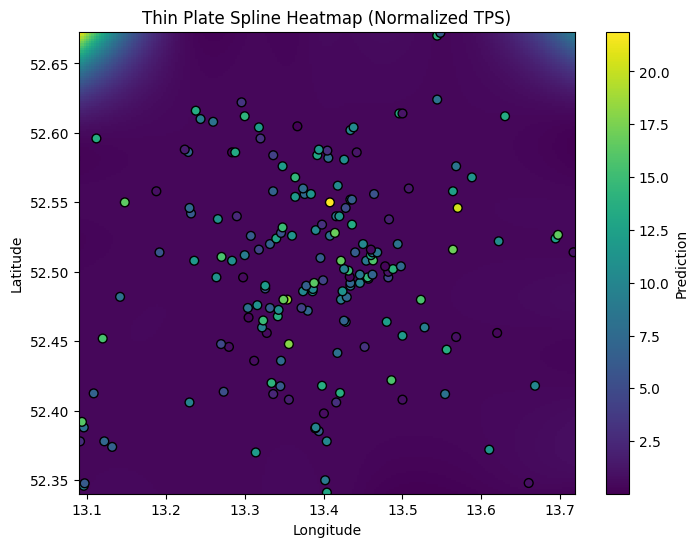

In [6]:
# Fit spline (Closed form LOOCV)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import SmoothBivariateSpline
from sklearn.preprocessing import StandardScaler

# Extract coordinates and z-values
lon = data["lon"].values
lat = data["lat"].values
z = data["predictions"].values

# 1. Normalize coordinates for TPS stability
scaler = StandardScaler()
XY = scaler.fit_transform(np.column_stack([lon, lat]))
x = XY[:, 0]
y = XY[:, 1]

# 2. Fit Thin Plate Spline with smoothing (s = 0.1 * n recommended)
s = 0#.1 * len(z)
spline = SmoothBivariateSpline(x, y, z, kx=3, ky=3, s=s)

# 3. Create grid in normalized space
x_grid = np.linspace(x.min(), x.max(), 200)
y_grid = np.linspace(y.min(), y.max(), 200)
X, Y = np.meshgrid(x_grid, y_grid)

# 4. Evaluate spline on normalized grid
Z = spline.ev(X.ravel(), Y.ravel()).reshape(X.shape)

# 5. Transform grid back to geographic coordinates
XY_grid = np.column_stack([X.ravel(), Y.ravel()])
lon_grid, lat_grid = scaler.inverse_transform(XY_grid).T
lon_grid = lon_grid.reshape(X.shape)
lat_grid = lat_grid.reshape(Y.shape)

# 6. Plot heatmap
plt.figure(figsize=(8, 6))
plt.pcolormesh(lon_grid, lat_grid, Z, shading="auto")
plt.scatter(lon, lat, c=z, edgecolor="black", s=40)
plt.colorbar(label="Prediction")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Thin Plate Spline Heatmap (Normalized TPS)")
plt.show()

Result: The points are sparse so the thin plate spline doesn't work very well. Onto Kriging.